c:\DL\venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.8057
Epoch 2/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3925 
Epoch 3/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2127 
Epoch 4/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794 
Epoch 5/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1325 
Epoch 6/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1437 
Epoch 7/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0935 
Epoch 8/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0859 
Epoch 9/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0861 
Epoch 10/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0718 
Epoch 11/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0696 
Epoch 12/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0631 
Epoch 13/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0713 
Epoch 14/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0563 
Epoch 15/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

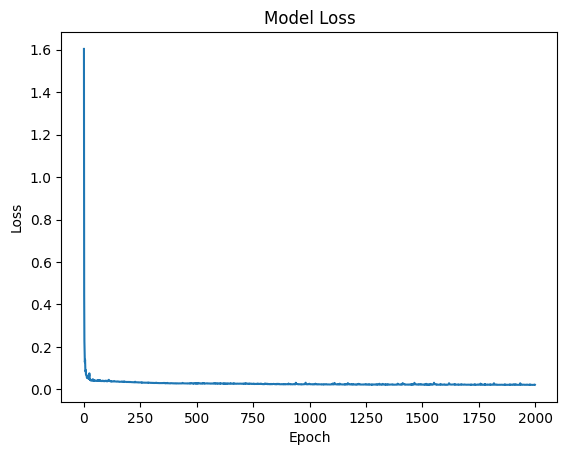

Reconstruction Error: 0.04136515688054726


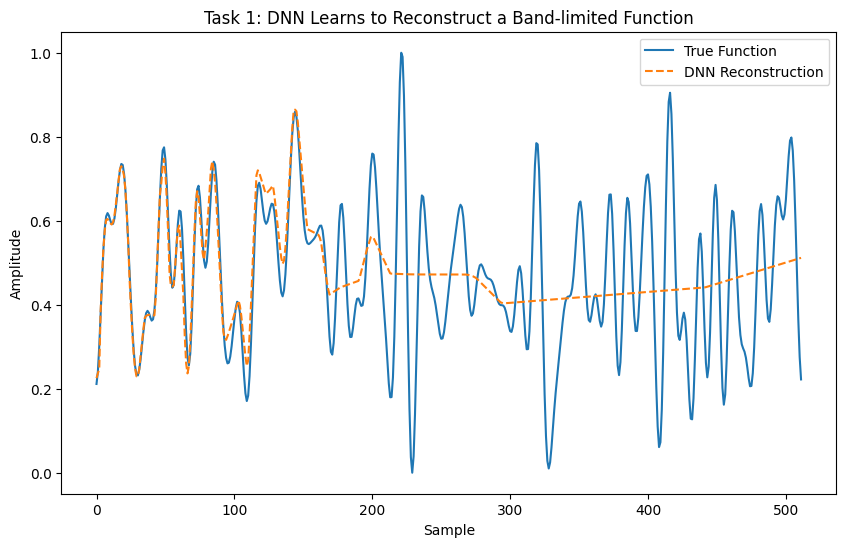

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE) on Training Data: 0.041062330648315194


In [2]:
# Task 1: 用DNN學習重建一個帶限制函數
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# 生成帶限制函數的數據集
np.random.seed(42) # Set random seed for reproducibility
N = 512  # Total number of points
M = 512  # Number of training points
band_limit = 50  # Band-limit
coefficients = np.zeros(N, dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數 
coefficients[1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
coefficients[-(band_limit-1):] = coefficients[1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_function = np.fft.ifft(coefficients).real  # 生成帶限制函數

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(1,)), #  L2 regularization
    tf.keras.layers.Dense(314, activation='relu'),
    tf.keras.layers.Dense(314, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(1, activation='linear') # 最後一層的激活函數為線性函數 使得輸出值不受限制 神經元的輸出值可以是任意實數
])

def normalized(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) # 正規化函數值 使其在 0 到 1 之間 用來更好的訓練模型

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數   
time_domain_function = normalized(time_domain_function) # 正規化函數值 使其在 0 到 1 之間 

# 訓練模型
x_train = np.linspace(1, N, M).reshape(-1, 1)  # 生成訓練數據 用來訓練模型
x_train = x_train.reshape(-1) # 將數據展平 為了更好的訓練效果
y_train = time_domain_function[x_train.astype(int) - 1].reshape(-1) # 生成訓練標籤 用來訓練模型
xy_combined = list(zip(x_train, y_train)) # 將數據集合併
random.shuffle(xy_combined) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
x_train, y_train = zip(*xy_combined) # 恢復數據集

x_train = np.array(x_train) # 將數據集轉換為 numpy 類型
y_train = np.array(y_train) # 將數據集轉換為 numpy 類型
x_train = x_train.reshape(-1, 1) # 將數據集轉換為二維數據
y_train = y_train.reshape(-1, 1) # 將數據集轉換為二維數據

history = model.fit(x_train, y_train, epochs=2000, batch_size=32, verbose=1) # 訓練模型

# 用訓練好的模型預測
x_test = np.linspace(1, N, N).reshape(-1, 1) # 生成測試數據 用來預測
y_pred = model.predict(x_test) # 預測

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#reconstruction error
y_pred = y_pred.reshape(-1) # 將預測值展平
y_train = y_train.reshape(-1) # 將真實值展平
reconstruction_error = np.mean((y_pred - y_train) ** 2) # 計算重建誤差
print(f'Reconstruction Error: {reconstruction_error}')

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_function, label='True Function') # 繪製真實函數
plt.plot(y_pred, label='DNN Reconstruction', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 1: DNN Learns to Reconstruct a Band-limited Function')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

Epoch 1/500


c:\DL\venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 68.1830 - val_loss: 3.1059
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3519 - val_loss: 1.0877
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0375 - val_loss: 0.9147
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9040 - val_loss: 0.8731
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8669 - val_loss: 0.8461
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8403 - val_loss: 0.8209
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8154 - val_loss: 0.7969
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7918 - val_loss: 0.7746
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7699 - val_loss: 0.7538
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7493 - val_loss: 0.7343
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7302 - val_loss: 0.7161
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7123 - val_loss: 0.6992


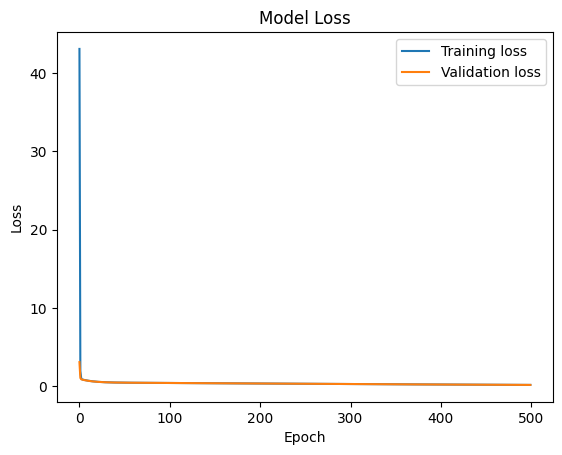

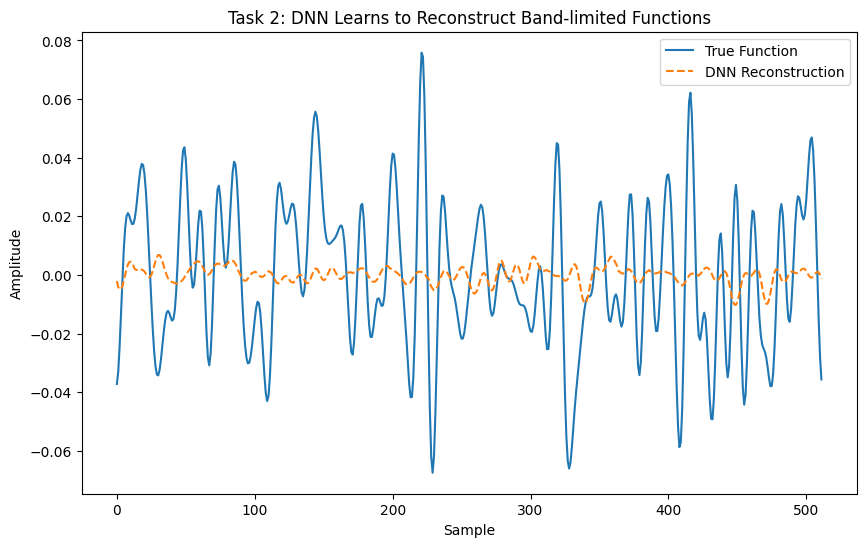

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE) on Training Data: 0.0007506657909148363
Model Loss: 0.19504541158676147


In [11]:
# Task 2: Reconstruction of Band-limited Functions
#1. Randomly Generate a M Target Function: Let M be the dataset size, using the codeexample above, randomly generate M band-limited function with input in the range x = 1 . . . 512 and with 50 non-zero Fourier coefficients. Let the randomly generated function at the mth iteration for m ∈ [1, . . . M ] is indicated as fm.
#2. Choose 100 sampling points For the set of 512 input choose 100 indexes – for example uniformly or exponentially spaced. Call the subset of indexes X.
#3. Dataset Preparation: Generate a dataset as follows: for the entry m ∈ [1, . . . , M ]
    #•the predictor is a vector of size 100 corresponding to fmevaluated on X
    #•the label is a vector of size 512 corresponding to fmevaluated on [1, . . . , 512].
#4. Network Training: Use the sampled points as the training dataset for a DNN. The network’s task is to learn the mapping from the sampled points back to the original band-limited function.
#5. Observation: Upon completing the training, evaluate how the network reconstructs the band-limited function. Analyze the network’s performance in terms of its ability to interpolate between the sampled points and how it generalizes the class of band-limited functions beyond the provided samples.
#6. Experiment with dataset size: Observe the change in approximation accuracy and overall quality as a function of the dataset size.
#7. Experiment with the choice of X: Observe the change in approximation accuracy and overall quality as a function the choice of X: regular or irregular.
#中文解釋
#1. 隨機生成 M 個目標函數：使用上面的代碼示例，隨機生成 M 個帶限制函數，其中 M 是數據集大小，輸入範圍為 x = 1 . . . 512，並且具有 50 個非零傅立葉系數。假設在第 m 次迭代中隨機生成的函數為 fm。
#2. 選擇 100 個採樣點：對於 512 個輸入選擇 100 個索引 - 例如均勻或指數間隔。將索引的子集命名為 X。
#3. 數據集準備：生成數據集如下：對於 m ∈ [1, . . . , M] 的條目
    #•預測器是大小為 100 的向量，對應於在 X 上評估的 fm
    #•標籤是大小為 512 的向量，對應於在 [1, . . . , 512] 上評估的 fm。
#4. 網絡訓練：使用採樣點作為 DNN 的訓練數據集。網絡的任務是學習從採樣點返回到原始帶限制函數的映射。
#5. 觀察：完成訓練後，評估網絡如何重建帶限制函數。分析網絡在插值採樣點方面的性能，以及它如何在提供的樣本之外泛化帶限制函數的類。
#6. 實驗數據集大小：觀察隨著數據集大小的變化，近似精度和整體質量的變化。
#7. 實驗 X 的選擇：觀察隨著 X 的選擇方式的變化，近似精度和整體質量的變化：正規或不規則。

# 生成 M 個帶限制函數
np.random.seed(42) # Set random seed for reproducibility
M = 512  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 100 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) # 生成訓練數據 用來訓練模型
y_data = np.zeros((M, N)) # 生成訓練標籤 用來訓練模型
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.5, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.5, random_state=42) # 將數據集分為訓練集和測試集

def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#Normalizing the function values to be between 0 and 1
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'), 
    tf.keras.layers.Dense(512, activation='linear') # 最後一層的激活函數為線性函數 使得輸出值不受限制 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.5) # 訓練模型 validation_split=0.1表示驗證集的比例是10%

# 用訓練好的模型預測
x_test = x_train
y_pred = model.predict(x_test) # 預測

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 31.2225 - val_loss: 1.5568
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2794 - val_loss: 0.9008
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8834 - val_loss: 0.8363
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8246 - val_loss: 0.7886
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7779 - val_loss: 0.7450
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7353 - val_loss: 0.7055
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6967 - val_loss: 0.6697
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6618 - val_loss: 0.6373
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6302 - val_loss: 0.6081
Epoch 10/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6017 - val_loss: 0.5818
Epoch 11/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5760 - val_loss: 0.5581
Epoch 12/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5529 - val_l

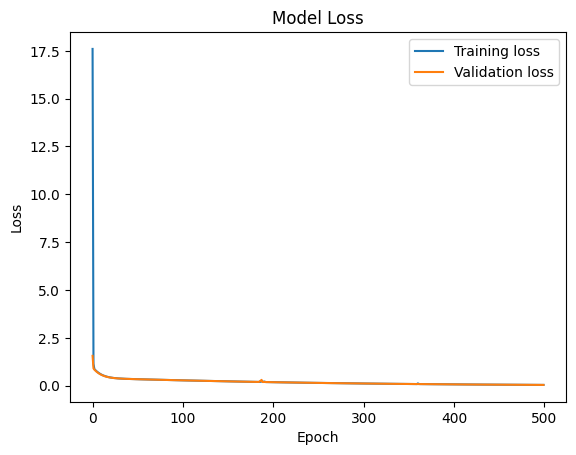

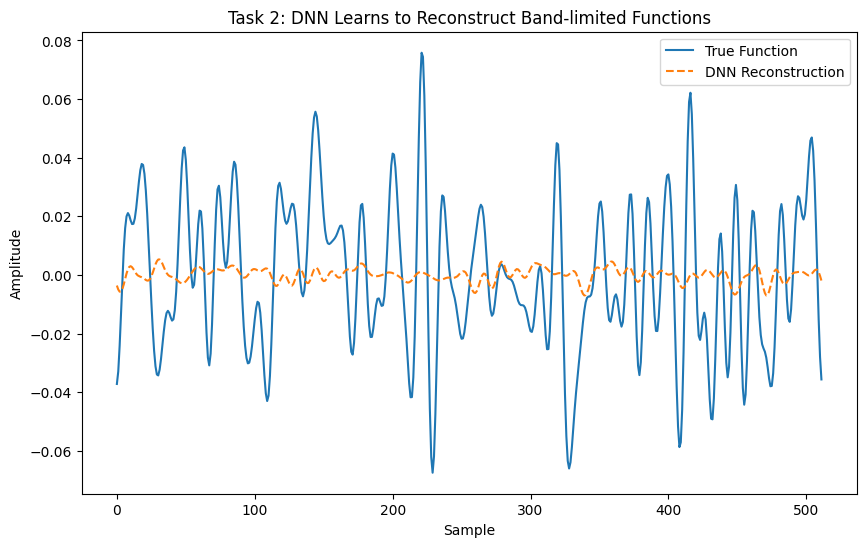

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE) on Training Data: 0.0007461711068451134
Model Loss: 0.03717545419931412


In [12]:
np.random.seed(42) # Set random seed for reproducibility
M = 512  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 200 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) #程式碼中的x_train是用來訓練模型的數據集，y_train是用來訓練模型的標籤集
y_data = np.zeros((M, N)) # 生成訓練標籤 用來訓練模型 N 為函數的總點數 不是N-num_samples 是N 因為要生成完整的函數
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.4, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.4, random_state=42) # 將數據集分為訓練集和測試集

def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#Normalizing the function values to be between 0 and 1
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'), 
    tf.keras.layers.Dense(512, activation='linear') # 最後一層的激活函數為線性函數 使得輸出值不受限制 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.4) # 訓練模型 validation_split=0.1表示驗證集的比例是10%

# 用訓練好的模型預測
x_test = x_train
y_pred = model.predict(x_test) # 預測

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 40.6294 - val_loss: 1.1753
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0393 - val_loss: 0.8681
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8534 - val_loss: 0.8102
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7976 - val_loss: 0.7599
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7488 - val_loss: 0.7158
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7062 - val_loss: 0.6773
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6689 - val_loss: 0.6439
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6366 - val_loss: 0.6148
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6085 - val_loss: 0.5896
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5841 - val_loss: 0.5678
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5630 - val_loss: 0.5489
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5448 - val_l

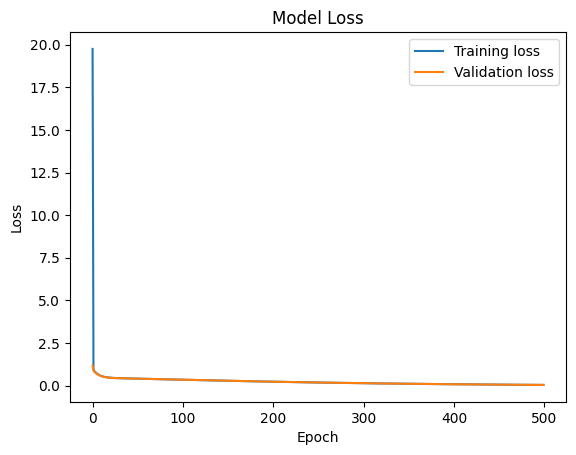

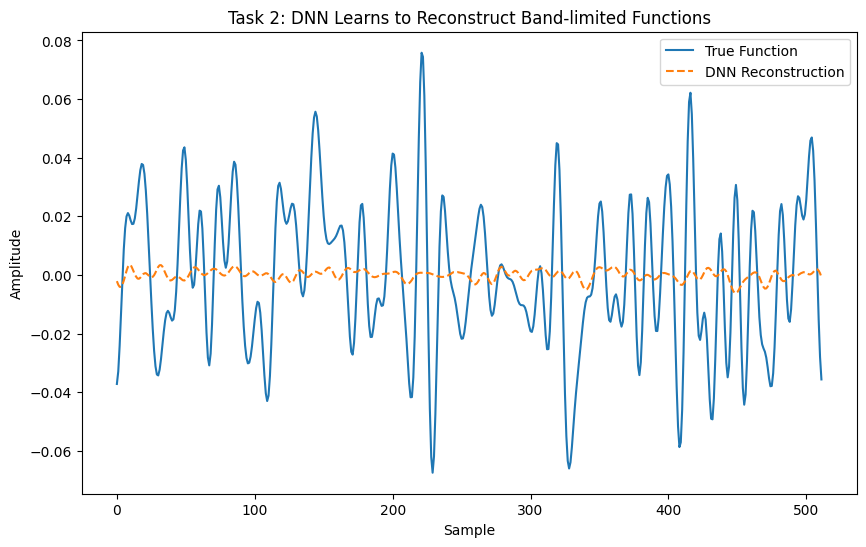

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE) on Training Data: 0.0007432570713473736
Model Loss: 0.039653368294239044


In [13]:
np.random.seed(42) # Set random seed for reproducibility
M = 512  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 200 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) #程式碼中的x_train是用來訓練模型的數據集，y_train是用來訓練模型的標籤集
y_data = np.zeros((M, N)) # 生成訓練標籤 用來訓練模型 N 為函數的總點數 不是N-num_samples 是N 因為要生成完整的函數
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.3, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.3, random_state=42) # 將數據集分為訓練集和測試集

def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#Normalizing the function values to be between 0 and 1
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'), 
    tf.keras.layers.Dense(512, activation='linear') # 最後一層的激活函數為線性函數 使得輸出值不受限制 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.3) # 訓練模型 validation_split=0.1表示驗證集的比例是10%

# 用訓練好的模型預測
x_test = x_train
y_pred = model.predict(x_test) # 預測

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 28.3976 - val_loss: 0.9361
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9005 - val_loss: 0.8336
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8171 - val_loss: 0.7693
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7554 - val_loss: 0.7155
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7040 - val_loss: 0.6710
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6614 - val_loss: 0.6342
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6263 - val_loss: 0.6039
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5974 - val_loss: 0.5789
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5736 - val_loss: 0.5584
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5541 - val_loss: 0.5416
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5380 - val_loss: 0.5277
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

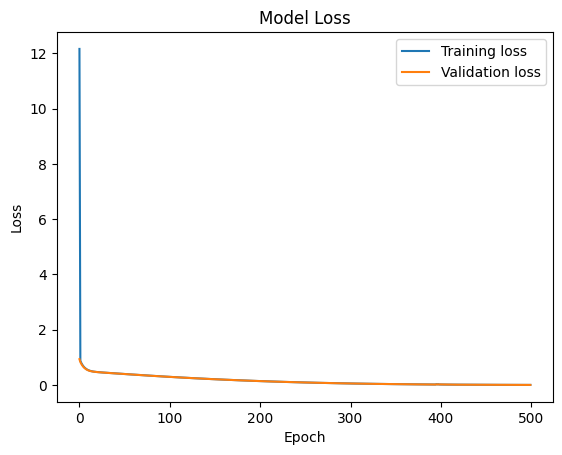

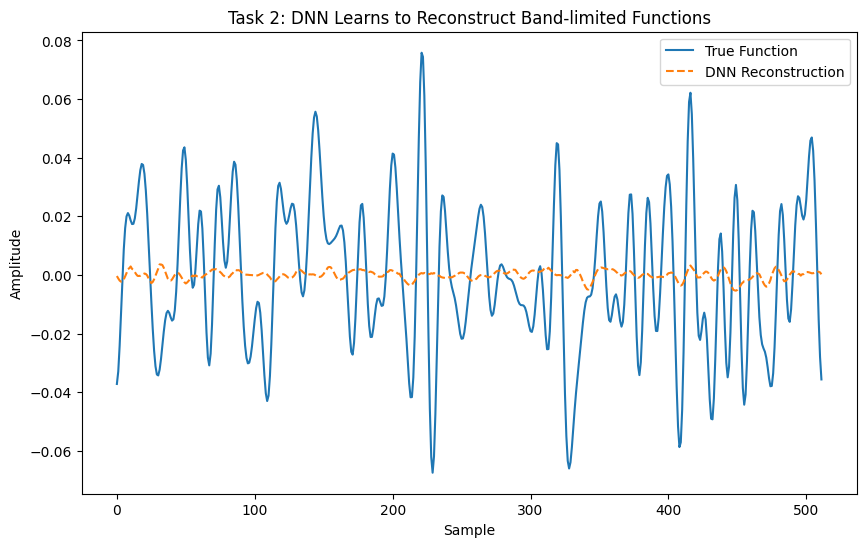

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE) on Training Data: 0.0007438156793993512
Model Loss: 0.004147012252360582


In [14]:
np.random.seed(42) # Set random seed for reproducibility
M = 512  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 200 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) #程式碼中的x_train是用來訓練模型的數據集，y_train是用來訓練模型的標籤集
y_data = np.zeros((M, N)) # 生成訓練標籤 用來訓練模型 N 為函數的總點數 不是N-num_samples 是N 因為要生成完整的函數
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.2, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.2, random_state=42) # 將數據集分為訓練集和測試集

def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#Normalizing the function values to be between 0 and 1
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'), 
    tf.keras.layers.Dense(512, activation='linear') # 最後一層的激活函數為線性函數 使得輸出值不受限制 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.2) # 訓練模型 validation_split=0.1表示驗證集的比例是10%

# 用訓練好的模型預測
x_test = x_train
y_pred = model.predict(x_test) # 預測

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.0855 - val_loss: 0.8270
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7800 - val_loss: 0.6526
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6171 - val_loss: 0.5162
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4869 - val_loss: 0.4055
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3820 - val_loss: 0.3169
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2982 - val_loss: 0.2467
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2319 - val_loss: 0.1914
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1797 - val_loss: 0.1481
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1391 - val_loss: 0.1145
Epoch 10/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1076 - val_loss: 0.0887
Epoch 11/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0833 - val_loss: 0.0689
Epoch 12/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

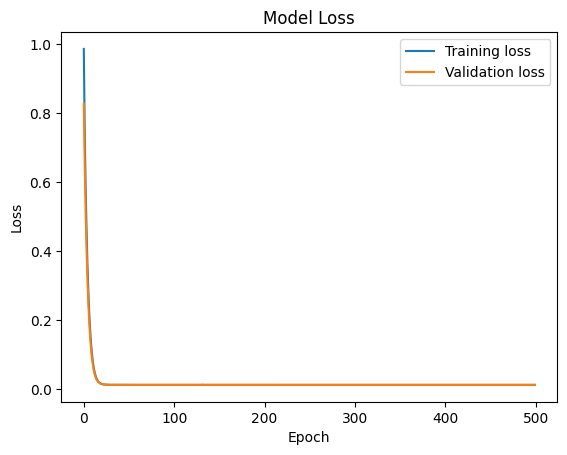

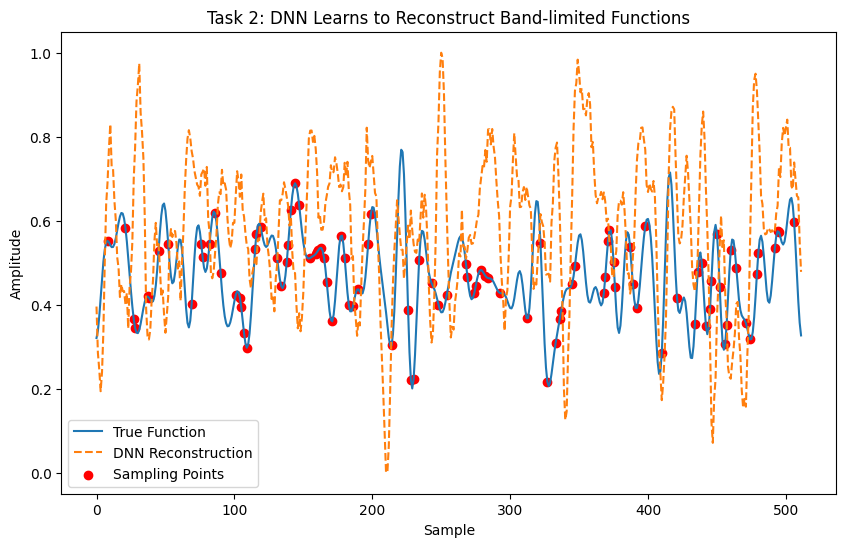

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE) on Training Data: 0.011757239526813784
Model Loss: 0.011757925152778625
Minimum validation loss: 0.011951401829719543


In [22]:
np.random.seed(42) # Set random seed for reproducibility
M = 512  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 100 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) 
y_data = np.zeros((M, N))
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.1, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.1, random_state=42) # 將數據集分為訓練集和測試集

def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#Normalizing the function values to be between 0 and 1
x_data = normalized(x_data)
y_data = normalized(y_data)
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'), 
    tf.keras.layers.Dense(512, activation='linear') # 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.1) # 訓練模型 validation_split=0.1表示驗證集的比例是10%


# 用訓練好的模型預測
y_pred = model.predict(x_test) # 預測

# 對預測的結果進行正規化
y_pred = normalized(y_pred)

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果 也將sampling points的點繪製出來
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.scatter(sample_indices, y_data[0][sample_indices], color='red', label='Sampling Points') # 繪製採樣點
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()


# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

vali_loss = history.history['val_loss']
print(f'Minimum validation loss: {min(vali_loss)}')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0583 - val_loss: 0.6985
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6311 - val_loss: 0.4521
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4065 - val_loss: 0.2876
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2578 - val_loss: 0.1809
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1619 - val_loss: 0.1135
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1018 - val_loss: 0.0719
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0648 - val_loss: 0.0468
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0426 - val_loss: 0.0320
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0295 - val_loss: 0.0233
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - val_loss: 0.0183
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0175 - val_loss: 0.0154
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

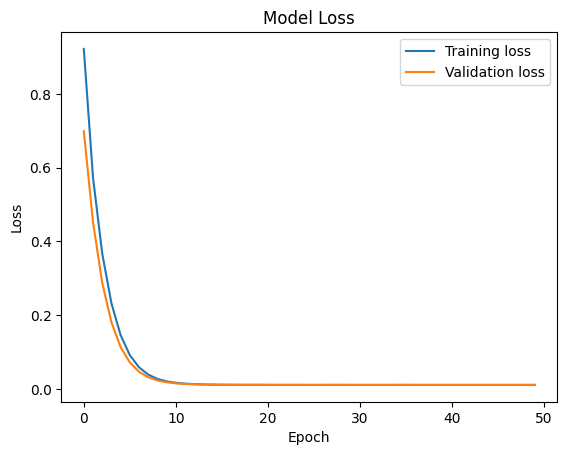

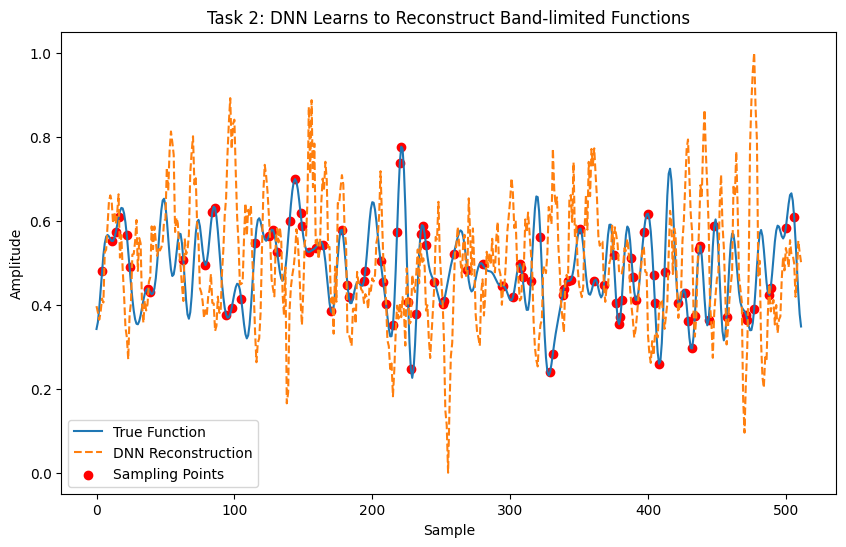

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE) on Training Data: 0.011168751948096531
Model Loss: 0.011170708574354649
Minimum validation loss: 0.01116167102009058


In [30]:
np.random.seed(42) # Set random seed for reproducibility
M = 1024  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 100 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) 
y_data = np.zeros((M, N))
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.1, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.1, random_state=42) # 將數據集分為訓練集和測試集

#Normalizing the function values to be between 0 and 1
def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

x_data = normalized(x_data)
y_data = normalized(y_data)
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(896, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(640, activation='relu'), 
    tf.keras.layers.Dense(512, activation='linear') # 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1) # 訓練模型 validation_split=0.1表示驗證集的比例是10%

# 用訓練好的模型預測
y_pred = model.predict(x_test) # 預測

# 對預測的結果進行正規化
y_pred = normalized(y_pred)


# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.scatter(sample_indices, y_data[0][sample_indices], color='red', label='Sampling Points') # 繪製採樣點
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

vali_loss = history.history['val_loss']
print(f'Minimum validation loss: {min(vali_loss)}')

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0477 - val_loss: 0.6481
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5753 - val_loss: 0.3932
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3483 - val_loss: 0.2349
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2077 - val_loss: 0.1387
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1229 - val_loss: 0.0866
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0753 - val_loss: 0.0510
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0485 - val_loss: 0.0371
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0330 - val_loss: 0.0230
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0225 - val_loss: 0.0189
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0172 - val_loss: 0.0141
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

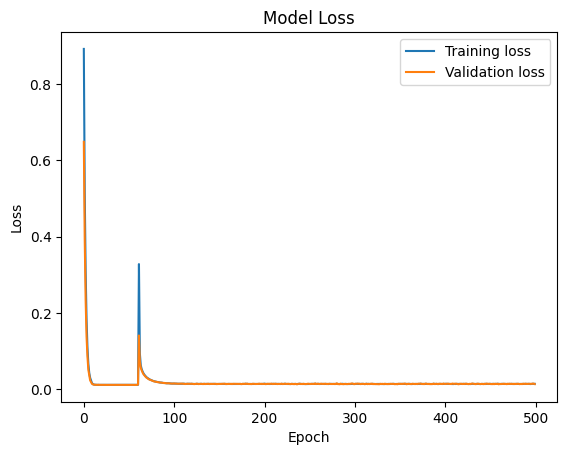

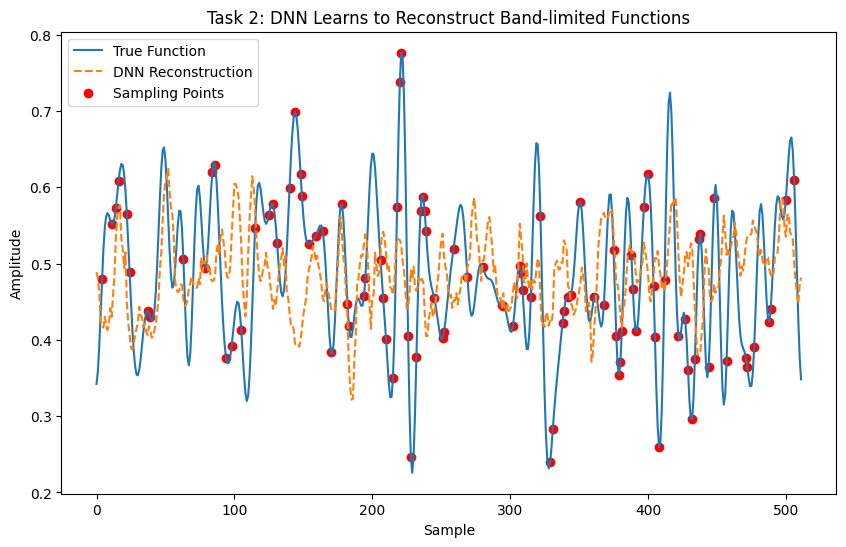

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE) on Training Data: 0.013479482041380867
Model Loss: 0.013479627668857574
Minimum validation loss: 0.011170417070388794


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

np.random.seed(42) # Set random seed for reproducibility
M = 1024  # Number of functions
N = 512  # Total number of points
band_limit = 50  # Band-limit

# 生成 M 個帶限制函數
coefficients = np.zeros((M, N), dtype=np.complex128) # 生成帶限制函數的傅立葉系數 用來生成帶限制函數
for i in range(M):
    coefficients[i, 1:band_limit] = np.random.randn(band_limit-1) + 1j * np.random.randn(band_limit-1) # 生成隨機傅立葉系數 用來生成帶限制函數
    coefficients[i, -(band_limit-1):] = coefficients[i, 1:band_limit][::-1].conj()  # 生成對稱的傅立葉系數 用來生成帶限制函數
time_domain_functions = np.fft.ifft(coefficients, axis=1).real  # 生成帶限制函數 共 M 個

# 選擇 100 個採樣點
num_samples = 100
sample_indices = np.random.choice(N, num_samples, replace=False) # 隨機選擇 100 個採樣點

# 生成數據集
x_data = np.zeros((M, num_samples)) 
y_data = np.zeros((M, N))
for i in range(M):
    x_data[i] = np.array([sample_indices]) # 將採樣點添加到訓練數據集
    y_data[i] = time_domain_functions[i] #time_domain_functions[i]是帶限制函數的值

def train_test_spilt(x_data, y_data, test_size=0.1, random_state=None): #test_size=0.1表示測試集的比例是10% random_state=None表示隨機種子為空
    np.random.seed(random_state) # Set random seed for reproducibility
    M = x_data.shape[0]
    indices = np.random.permutation(M) # 打亂數據集 為了更好的訓練效果 防止模型過擬合
    x_data = x_data[indices]
    y_data = y_data[indices]
    split_index = int(M * (1 - test_size))
    x_train, x_test = x_data[:split_index], x_data[split_index:] # 將數據集分為訓練集和測試集
    y_train, y_test = y_data[:split_index], y_data[split_index:] # 將數據集分為訓練集和測試集
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_spilt(x_data, y_data, test_size=0.1, random_state=42) # 將數據集分為訓練集和測試集

def normalized(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#Normalizing the function values to be between 0 and 1
x_data = normalized(x_data)
y_data = normalized(y_data)
x_train = normalized(x_train)
y_train = normalized(y_train)
x_test = normalized(x_test)
y_test = normalized(y_test)

#將原本的time_domain_functions也進行正規化
time_domain_functions = normalized(time_domain_functions)

# 定義DNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(num_samples,)), # 添加 L2 正則化 防止過擬合 第一層的輸入維度為採樣點的數量
    tf.keras.layers.Dense(896, activation='tanh'),
    tf.keras.layers.Dense(896, activation='tanh'),
    tf.keras.layers.Dense(768, activation='tanh'),
    tf.keras.layers.Dense(768, activation='tanh'),
    tf.keras.layers.Dense(640, activation='tanh'),
    tf.keras.layers.Dense(640, activation='tanh'),
    tf.keras.layers.Dense(640, activation='tanh'), 
    tf.keras.layers.Dense(512, activation='linear') # 神經元數為函數的總點數
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse') # 使用 Adam 優化器 並使用均方誤差作為損失函數

# 訓練模型
history = model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.1) # 訓練模型 validation_split=0.1表示驗證集的比例是10%

# 用訓練好的模型預測
y_pred = model.predict(x_test) # 預測

# 繪製訓練過程中的損失曲線
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss') # 繪製驗證損失 和 loss 的差別是驗證損失是用來評估模型的損失 loss是用來訓練模型的損失
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(time_domain_functions[0], label='True Function') # 繪製真實函數
plt.plot(y_pred[0], label='DNN Reconstruction', linestyle='--')
plt.scatter(sample_indices, y_data[0][sample_indices], color='red', label='Sampling Points') # 繪製採樣點
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Task 2: DNN Learns to Reconstruct Band-limited Functions')
plt.legend()
plt.show()

# 評估模型準確度
y_pred_train = model.predict(x_train)
mse = np.mean((y_pred_train - y_train) ** 2)
print(f'Mean Squared Error (MSE) on Training Data: {mse}')

# 評估模型
loss = model.evaluate(x_train, y_train, verbose=0)
print(f'Model Loss: {loss}')

vali_loss = history.history['val_loss']
print(f'Minimum validation loss: {min(vali_loss)}')